## Mixed Model NBA Shooting Predictor

In [25]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.1 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


#### Table of contents
    1. Motivation
    2. Exploratory Data Analysis

#### Motivation

The goal of this project to is to explore mixed effect modeling on a players shooting ability and build a model that can accurately predict a players ability to make a shot given different features. Some features that will be explored include where the player is located on the floor and the opposing teams defender/team defensive ratings. 
    
With mixed effects models it is important to first determine whether the variables should be treated as random effects or fixed effects. If the effect will be similar amoung groups (players) the effect will be fixed, if they effects are different among groups the effects will be randon



In [12]:
#import libraries
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from py_ball import player, playbyplay
from sklearn.model_selection import train_test_split

In [13]:
HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

#### Exploratory 

Exploring data available through the py_ball api. First creating a baseline model using just the players location on the floor and the type of shot they are taking.

In [14]:
#getting the shotchart for the 22-23 regular season
league_id = '00' #NBA
player_id = '0' #All players

season = '2022-23'
x=season.split('0',1)[1]
season_split = x.split('-',1)[0]
all_df = pd.DataFrame({})

for x in range(1,1231):
    print('Game #' + str(x))
    t0 = time.time()
    game_id = '002'+ season_split +'0'+ str(x).zfill(4)
    shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
    shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
    all_df = pd.concat([all_df, shot_df], axis=0).reset_index(drop=True)
    delay = time.time() - t0
    print('Waiting ' + str(10*delay) + 's')
    time.sleep(delay)
    
all_df.to_csv('shotchart.csv', index=False)

Game #1
Waiting 3.135201930999756s
Game #2
Waiting 3.5349488258361816s
Game #3


KeyboardInterrupt: 

In [15]:
pd.set_option('display.max_columns', None)
shot_chart = pd.read_csv(r'/home/neil/Desktop/shotchart.csv')


In [16]:
shot_chart

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,22200001,7,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,38,Missed Shot,Turnaround Fadeaway shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,12,-118,50,1,0,20221018,BOS,PHI
1,Shot Chart Detail,22200001,11,203935,Marcus Smart,1610612738,Boston Celtics,1,11,15,Made Shot,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,13,120,55,1,1,20221018,BOS,PHI
2,Shot Chart Detail,22200001,12,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,5,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,50,135,1,0,20221018,BOS,PHI
3,Shot Chart Detail,22200001,14,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,3,Made Shot,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1,1,20221018,BOS,PHI
4,Shot Chart Detail,22200001,15,1628369,Jayson Tatum,1610612738,Boston Celtics,1,10,46,Made Shot,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,23,-232,49,1,1,20221018,BOS,PHI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217215,Shot Chart Detail,22201230,634,1630541,Moses Moody,1610612744,Golden State Warriors,4,1,11,Made Shot,Cutting Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,11,3,1,1,20230409,POR,GSW
217216,Shot Chart Detail,22201230,636,1631219,John Butler Jr.,1610612757,Portland Trail Blazers,4,1,0,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,224,84,1,1,20230409,POR,GSW
217217,Shot Chart Detail,22201230,638,1630228,Jonathan Kuminga,1610612744,Golden State Warriors,4,0,44,Missed Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,23,199,126,1,0,20230409,POR,GSW
217218,Shot Chart Detail,22201230,640,1631116,Patrick Baldwin,1610612744,Golden State Warriors,4,0,36,Missed Shot,Driving Floating Bank Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),8-16 ft.,8,-71,52,1,0,20230409,POR,GSW


In [17]:
shot_chart['ACTION_TYPE'].value_counts()

ACTION_TYPE
Jump Shot                             63981
Pullup Jump shot                      27214
Driving Layup Shot                    19169
Driving Floating Jump Shot            11246
Step Back Jump shot                   10457
Running Layup Shot                     6766
Layup Shot                             5824
Cutting Layup Shot                     5518
Driving Finger Roll Layup Shot         5516
Tip Layup Shot                         4685
Running Jump Shot                      4398
Floating Jump shot                     4331
Fadeaway Jump Shot                     3923
Putback Layup Shot                     3525
Driving Floating Bank Jump Shot        3356
Cutting Dunk Shot                      3340
Turnaround Fadeaway shot               3214
Turnaround Jump Shot                   2868
Running Pull-Up Jump Shot              2601
Running Dunk Shot                      2569
Turnaround Hook Shot                   2546
Driving Reverse Layup Shot             2218
Driving Dunk Shot   

In [18]:
def feature_engineering(shotchart_df):
    """ feature_engineering calculates engineered
    features from the shotchart data

    @param shotchart_df (DataFrame): DataFrame containing
    shotchart data

    Returns:

        shotchart_df (DataFrame): DataFrame containing
        the engineered features
    """

    shotchart_df['ANGLE'] = abs(np.rad2deg(np.arctan2(shotchart_df['LOC_X'],
                                                      shotchart_df['LOC_Y'])))

    shotchart_df['SIDE'] = [1 if x >= 0 else 0 for x in shotchart_df['LOC_X']]

    shotchart_df['DUNK'] = [1 if 'Dunk' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['HOOK'] = [1 if 'Hook' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['LAYUP'] = [1 if 'Layup' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['JUMP'] = [1 if 'Jump' in x else 0 for x in shotchart_df['ACTION_TYPE']]

    shotchart_df = shotchart_df[['PLAYER_NAME','PLAYER_ID','HTM','VTM','SHOT_DISTANCE', 'ANGLE', 'SIDE', 'DUNK', 'HOOK', 'LAYUP', 'JUMP','SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG']]

    return shotchart_df

In [19]:
shotchart = feature_engineering(shot_chart)

In [20]:
shotchart

,PLAYER_NAME,PLAYER_ID,HTM,VTM,SHOT_DISTANCE,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Joel Embiid,203954,BOS,PHI,12,67.036227,0,0,0,0,0,1,0
1,Marcus Smart,203935,BOS,PHI,13,65.376435,1,0,0,0,1,1,1
2,Tobias Harris,202699,BOS,PHI,14,20.323137,1,0,0,0,1,1,0
3,Tobias Harris,202699,BOS,PHI,0,0.000000,1,0,0,1,0,1,1
4,Jayson Tatum,1628369,BOS,PHI,23,78.074008,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217215,Moses Moody,1630541,POR,GSW,1,74.744881,1,1,0,0,0,1,1
217216,John Butler Jr.,1631219,POR,GSW,23,69.443955,1,0,0,0,1,1,1
217217,Jonathan Kuminga,1630228,POR,GSW,23,57.659407,1,0,0,0,1,1,0
217218,Patrick Baldwin,1631116,POR,GSW,8,53.781163,0,0,0,0,1,1,0


In [21]:
shotchart['SHOT_MADE_FLAG'].value_counts()

SHOT_MADE_FLAG
0    113960
1    103260
Name: count, dtype: int64

Checking the split of which shots are being made. Seems to display almost even split

Next splitting the data into test and training sets

In [37]:
output = list(shotchart['SHOT_MADE_FLAG'])
shotchart = shotchart.drop(['SHOT_MADE_FLAG'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(shotchart, output, test_size=0.1, random_state=489)

In [69]:
#aside
players_shots = shotchart.groupby(by=['PLAYER_ID'],as_index=False).sum()


In [70]:
players_shots = players_shots.drop(['PLAYER_NAME','HTM','VTM','SHOT_DISTANCE','ANGLE'],axis=1)

In [72]:
players_shots

,PLAYER_ID,SIDE,DUNK,HOOK,LAYUP,JUMP,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,2544,603,76,7,442,620,1219,609
1,2617,16,1,0,5,23,29,10
2,2738,10,4,0,2,9,15,7
3,101108,365,0,0,21,643,668,294
4,200752,151,13,2,36,225,288,109
...,...,...,...,...,...,...,...,...
532,1631323,173,13,1,45,252,312,115
533,1631367,0,0,0,0,3,3,1
534,1631466,22,6,3,21,9,39,24
535,1631495,4,0,0,3,2,5,2


### Model Building

#### Non Hierarchical Logistic Regression

Starting building a simple baseline logistic model for a players shooting percentages on the floor. 

Using The bambi library we first note that this is a Binomial family where the response variable involves the shots made 'SHOT_MADE_FLAG' and the number of shots taken ' '. we can use the p(x,n) function for the response term. to tell Bambi the model should proportion results dividing x/n


In [73]:
model_non_hierarchical = bmb.Model("p(SHOT_MADE_FLAG, SHOT_ATTEMPTED_FLAG) ~ 0 + PLAYER_ID", players_shots, family="binomial")
model_non_hierarchical

       Formula: p(SHOT_MADE_FLAG, SHOT_ATTEMPTED_FLAG) ~ 0 + PLAYER_ID
        Family: binomial
          Link: p = logit
  Observations: 537
        Priors: 
    target = p
        Common-level effects
            PLAYER_ID ~ Normal(mu: 0.0, sigma: 0.0)

In [78]:
model_non_hierarchical = bmb.Model("p(SHOT_MADE_FLAG, SHOT_ATTEMPTED_FLAG) ~ 1+ (1|PLAYER_ID)", players_shots, family="binomial")
model_non_hierarchical

       Formula: p(SHOT_MADE_FLAG, SHOT_ATTEMPTED_FLAG) ~ 1+ (1|PLAYER_ID)
        Family: binomial
          Link: p = logit
  Observations: 537
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|PLAYER_ID ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))

In [74]:
idata_non_hierarchical = model_non_hierarchical.fit(random_seed=438)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [PLAYER_ID]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


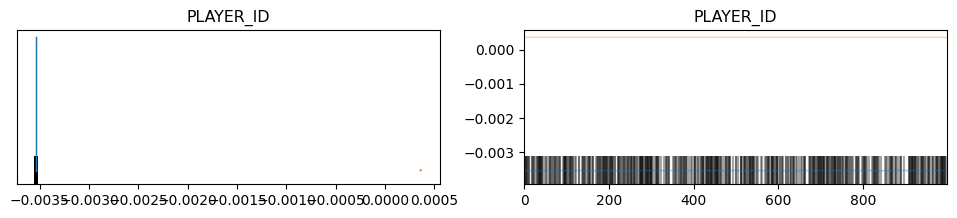

In [23]:
from pymer4.models import Lmer

model = Lmer("ANGLE  + (1|PLAYER_ID)",
             data=shotchart, family = 'binomial')

print(model.fit())

PackageNotInstalledError: The R package "lme4" is not installed.